# Example of Taylor series expansion of potential energy surface (PES) for ammonia

Here, we use the following internal coordinates of ammonia molecule $\text{NH}_3$:

1. $r_1$
2. $r_2$
3. $r_3$
4. $s_4 = (2\beta_{23}-\beta_{13}-\beta_{12})/\sqrt{6}$
5. $s_5 = (\beta_{13}-\beta_{12})/\sqrt{2}$
6. $\tau$

where $r_i\equiv\text{N-H}_i$, $\beta_{ij}$ are the $\text{H}_i\text{-C-H}_j$-valence-angle projections onto a plane perpendicular to the $z$-N trisector axis, and $\tau$ is an 'umbrella' angle $[-\pi,\pi]$.

We will build expansion of the PES in terms of the following transformed coordinates, which are 1D functions of internal coordinates:

- $y_1=1-\exp(-a_m(r_1-r_1^{(eq)}))$
- $y_2=1-\exp(-a_m(r_2-r_2^{(eq)}))$
- $y_3=1-\exp(-a_m(r_3-r_3^{(eq)}))$
- $y_4=s_4$
- $y_5=s_5$
- $y_6=\sin(\rho)$, where $\rho=\tau+\pi/2$

The PES of ammonia is adapted from [O. L. Polyansky, R. I. Ovsyannikov, A. A. Kyuberis, L. Lodi, J. Tennyson, A. Yachmenev, S. N. Yurchenko, N. F. Zobov, "Calculation of rotation-vibration energy levels of the ammonia molecule based on an ab initio potential energy surface", J. Mol. Spectrosc. 327, 21-30 (2016)](https://doi.org/10.1016/j.jms.2016.08.003). See Python implementation in [nh3_POK.py](../vibrojet/potentials/nh3_POK.py).

In [1]:
import itertools
import os

import jax
import matplotlib.pyplot as plt
import numpy as np
from jax import config
from jax import numpy as jnp
from scipy import optimize

from vibrojet.jet_prim import acos
from vibrojet.potentials import nh3_POK
from vibrojet.taylor import deriv_list

plt.rcParams.update(
    {"text.usetex": True, "font.family": "serif", "font.serif": ["Computer Modern"]}
)

config.update("jax_enable_x64", True)

Find equilibrium values of internal coordinates.

In [2]:
@jax.jit
def poten(q):
    r1, r2, r3, s4, s5, tau = q
    rho = tau + np.pi / 2

    beta1 = jnp.sqrt(6) / 3 * s4 + 2 * np.pi / 3
    beta2 = -1 / jnp.sqrt(6) * s4 + 1 / jnp.sqrt(2) * s5 + 2 * np.pi / 3
    beta3 = -1 / jnp.sqrt(6) * s4 - 1 / jnp.sqrt(2) * s5 + 2 * np.pi / 3

    cosrho = jnp.cos(rho)
    sinrho = jnp.sin(rho)
    cosrho2 = cosrho * cosrho
    sinrho2 = sinrho * sinrho

    cosalpha2 = cosrho2 + sinrho2 * jnp.cos(beta2)
    cosalpha3 = cosrho2 + sinrho2 * jnp.cos(beta3)
    cosalpha1 = cosrho2 + sinrho2 * jnp.cos(beta2 + beta3)
    alpha1 = acos(cosalpha1)
    alpha2 = acos(cosalpha2)
    alpha3 = acos(cosalpha3)
    v = nh3_POK.poten((r1, r2, r3, alpha1, alpha2, alpha3))
    return v


vmin = optimize.minimize(poten, [1.1, 1.1, 1.1, 0.1, 0.1, 0.1])
q0 = vmin.x
v0 = vmin.fun

print("equilibrium coordinates:", q0)
print("min of the potential:", v0)

equilibrium coordinates: [1.01159999e+00 1.01159999e+00 1.01159999e+00 6.95820540e-09
 2.12731136e-09 3.85722364e-01]
min of the potential: 3.4875128536984075e-11


Define mapping from internal coordinates to the transformed ($y$) coordinates

In [3]:
# y-coordinates for expansion of PES

# Morse constant necessary for defining y-coordinates for stretches
a_morse = 2.0


def internal_to_y(q):
    r1, r2, r3, s4, s5, tau = q
    rho = tau + jnp.pi/2
    y1 = 1 - jnp.exp(-a_morse * (r1 - q0[0]))
    y2 = 1 - jnp.exp(-a_morse * (r2 - q0[1]))
    y3 = 1 - jnp.exp(-a_morse * (r3 - q0[2]))
    y4 = s4
    y5 = s5
    y6 = jnp.sin(rho)
    return jnp.array([y1, y2, y3, y4, y5, y6])


def y_to_internal(y):
    y1, y2, y3, y4, y5, y6 = y
    r1 = -jnp.log(1 - y1) / a_morse + q0[0]
    r2 = -jnp.log(1 - y2) / a_morse + q0[1]
    r3 = -jnp.log(1 - y3) / a_morse + q0[2]
    s4 = y4
    s5 = y5
    rho = np.pi / 2 - acos(y6)  # asin(y6)
    tau = rho - np.pi/2
    return jnp.array([r1, r2, r3, s4, s5, tau])


y0 = internal_to_y(q0)

In [4]:
print("Reference values of internal coordinates:\n", q0)
print("Reference values of transformed y-coordinates:\n", y0)

Reference values of internal coordinates:
 [1.01159999e+00 1.01159999e+00 1.01159999e+00 6.95820540e-09
 2.12731136e-09 3.85722364e-01]
Reference values of transformed y-coordinates:
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 6.95820540e-09
 2.12731136e-09 9.26526900e-01]


Generate expansion power indices.

In [5]:
max_order = 4  # max total expansion order
deriv_ind = [
    elem
    for elem in itertools.product(*[range(0, max_order + 1) for _ in range(len(q0))])
    if sum(elem) <= max_order
]
print("max expansion order:", max_order)
print("number of expansion terms:", len(deriv_ind))

max expansion order: 4
number of expansion terms: 210


Generate expansion of PES in terms of internal coordinates.

In [6]:
@jax.jit
def poten(q):
    r1, r2, r3, s4, s5, tau = q
    rho = tau + np.pi / 2

    beta1 = jnp.sqrt(6) / 3 * s4 + 2 * np.pi / 3
    beta2 = -1 / jnp.sqrt(6) * s4 + 1 / jnp.sqrt(2) * s5 + 2 * np.pi / 3
    beta3 = -1 / jnp.sqrt(6) * s4 - 1 / jnp.sqrt(2) * s5 + 2 * np.pi / 3

    cosrho = jnp.cos(rho)
    sinrho = jnp.sin(rho)
    cosrho2 = cosrho * cosrho
    sinrho2 = sinrho * sinrho

    cosalpha2 = cosrho2 + sinrho2 * jnp.cos(beta2)
    cosalpha3 = cosrho2 + sinrho2 * jnp.cos(beta3)
    cosalpha1 = cosrho2 + sinrho2 * jnp.cos(beta2 + beta3)
    alpha1 = acos(cosalpha1)
    alpha2 = acos(cosalpha2)
    alpha3 = acos(cosalpha3)
    v = nh3_POK.poten((r1, r2, r3, alpha1, alpha2, alpha3))
    return v


poten_file = f"_nh3_poten_beta_coefs_{max_order}.npz"
if os.path.exists(poten_file):
    print(
        f"load potential expansion coefs from file {poten_file} (delete file to recompute coefs)"
    )
    data = np.load(poten_file)
    poten_coefs = data["coefs"]
else:
    poten_coefs = deriv_list(poten, deriv_ind, q0, if_taylor=True)
    np.savez(poten_file, coefs=poten_coefs, ind=deriv_ind, q0=y0)

load potential expansion coefs from file _nh3_poten_beta_coefs_4.npz (delete file to recompute coefs)


Generate expansion of PES in terms of transformed ($y$) internal coordinates.

In [7]:
@jax.jit
def poten_y(y):
    q = y_to_internal(y)
    return poten(q)


poten_file = f"_nh3_poten_beta_y_coefs_{max_order}.npz"
if os.path.exists(poten_file):
    print(
        f"load potential expansion coefs from file {poten_file} (delete file to recompute coefs)"
    )
    data = np.load(poten_file)
    poten_y_coefs = data["coefs"]
else:
    poten_y_coefs = deriv_list(poten_y, deriv_ind, y0, if_taylor=True)
    np.savez(poten_file, coefs=poten_y_coefs, ind=deriv_ind, q0=y0)

load potential expansion coefs from file _nh3_poten_beta_y_coefs_4.npz (delete file to recompute coefs)


Plot 1D cuts of PES along selected coordinates.

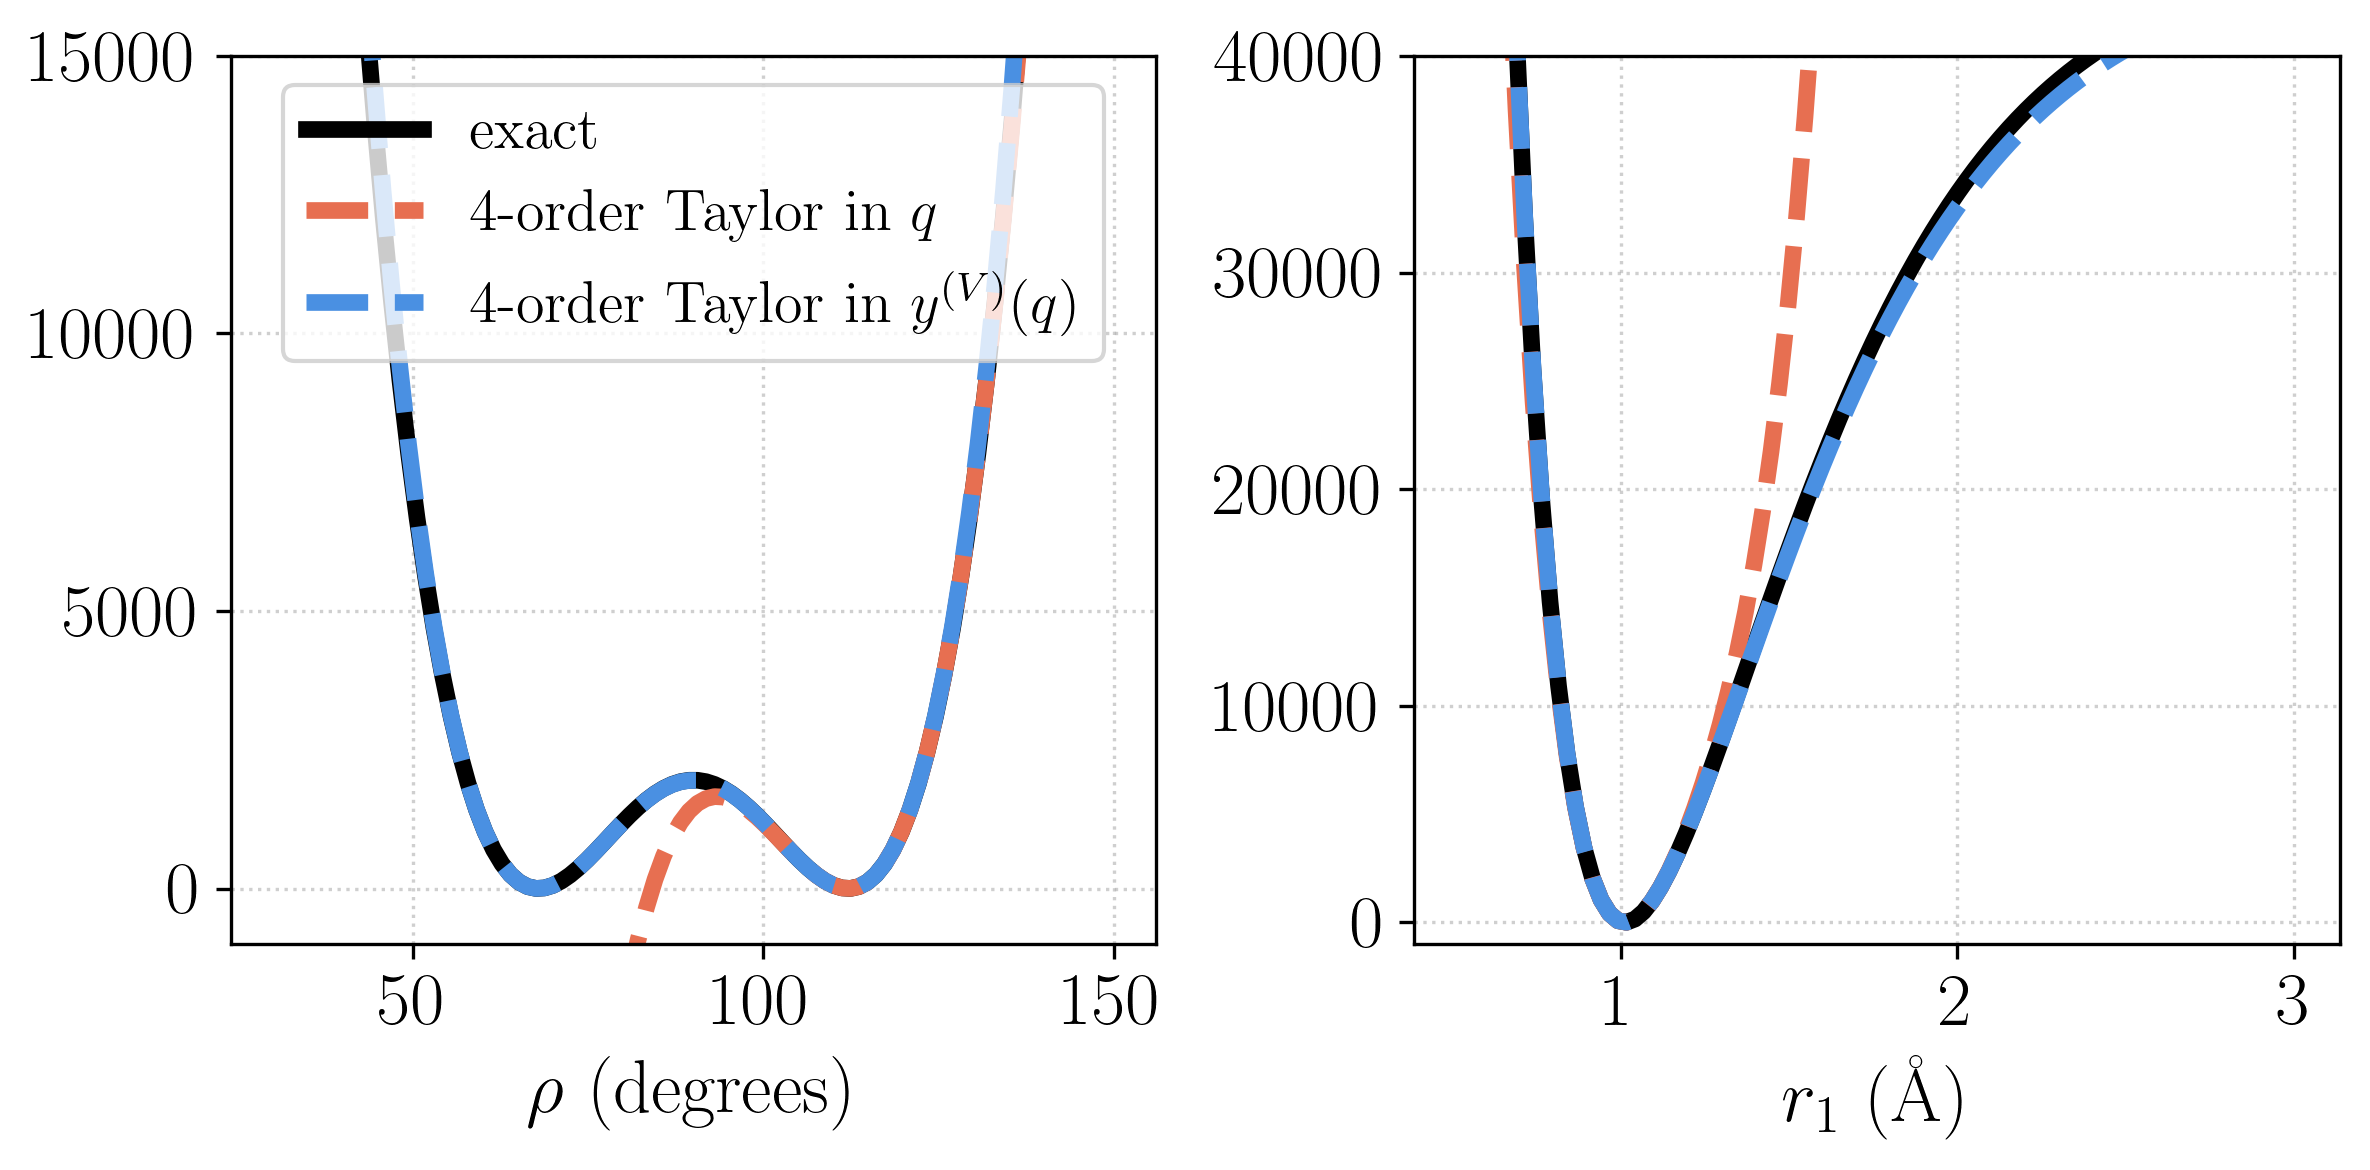

In [8]:
poten_taylor = jax.vmap(
    lambda x, x0, coefs, ind: jnp.sum(
        coefs * jnp.prod((x - x0)[None, :] ** jnp.array(ind), axis=-1)
    ),
    in_axes=(0, None, None, None),
)

# along tau coordinate

tau = np.linspace(-60 * np.pi / 180, 60 * np.pi / 180, 100)
q = np.ones((len(tau), 6)) * np.array(q0)[None, :]
q[:, -1] = tau
y = jax.vmap(internal_to_y)(q)
tau_deg = tau * 180 / np.pi
rho_deg = 90 + tau_deg

v_pts_tau = jax.vmap(poten)(q)
v_taylor_tau = poten_taylor(q, q0, poten_coefs, deriv_ind)
v_in_y_taylor_tau = poten_taylor(y, y0, poten_y_coefs, deriv_ind)

# along r1 coordinate

r = np.linspace(q0[0] - 0.5, q0[0] + 2, 100)
q = np.ones((len(r), 6)) * np.array(q0)[None, :]
q[:, 0] = r
y = jax.vmap(internal_to_y)(q)
v_pts_r = jax.vmap(poten)(q)
v_taylor_r = poten_taylor(q, q0, poten_coefs, deriv_ind)
v_in_y_taylor_r = poten_taylor(y, y0, poten_y_coefs, deriv_ind)


fig, axes = plt.subplots(1, 2, figsize=(8, 4), dpi=300)

for ax, (x, x_lab, v_pts, v_taylor, v_in_y_taylor, v_lim, leg) in zip(
    axes.flat,
    (
        (
            rho_deg,
            "$\\rho$ (degrees)",
            v_pts_tau,
            v_taylor_tau,
            v_in_y_taylor_tau,
            15000,
            True,
        ),
        (r, "$r_1$ (\\AA)", v_pts_r, v_taylor_r, v_in_y_taylor_r, 40000, False),
    ),
):
    ax.plot(x, v_pts, "-", linewidth=4, color="k", label="exact")
    ax.plot(
        x,
        v_taylor,
        "--",
        linewidth=4,
        color="#e76f51",
        label=f"{max_order}-order Taylor in $q$",
    )
    ax.plot(
        x,
        v_in_y_taylor,
        "--",
        linewidth=4,
        color="#4a90e2",
        label=f"{max_order}-order Taylor in "+"$y^{(V)}(q)$",
    )

    ax.set_xlabel(x_lab, fontsize=18)
    ax.grid(True, linestyle=":", alpha=0.6)
    if leg:
        ax.legend(fontsize=14, loc="upper center")
    ax.tick_params(axis="both", labelsize=18)
    ax.set_ylim([-1000, v_lim])

plt.tight_layout()
plt.savefig(f"_nh3_pes_beta_{max_order}.pdf", format="pdf", bbox_inches="tight")